# Geometrical Methods in Machine Learning
## Seminar 2: ICA

In [2]:
from __future__ import print_function

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import math as m
from scipy import signal
from scipy.linalg import fractional_matrix_power as matrix_power

from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler

## 1. ICA model

Consider ICA model:

$$\mathbf{X} = \mathbf{A}\mathbf{S}$$

where $\mathbf{S} \in \mathbb{R}^n$ is the source signal, $\mathbf{X} \in \mathbb{R}^m$ - observed data, $\mathbf{A}$ - $m \times n$ mixing matrix, where $m \geq n, \mathrm{Rank}(\mathbf{A}) = n$. 

In [3]:
np.random.seed(66)
S = np.random.logistic(0, 1, (2, 2000)) ** 3
S = S / S.std()
S[0, :] /= 4.

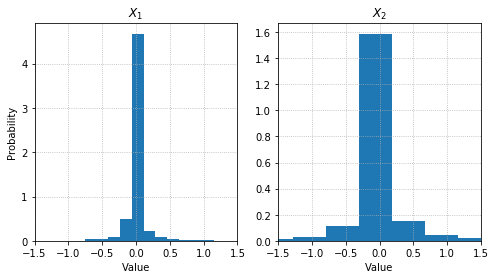

In [5]:
fig = plt.figure(figsize=(8,4))

plt.subplot(121)
plt.xlim(-1.5, 1.5)
plt.xlabel("Value")
plt.ylabel("Probability")
plt.grid(linestyle="dotted")
plt.title("$X_1$")
plt.hist(S[0,:], bins=50, density=True)

plt.subplot(122)
plt.xlim(-1.5, 1.5)
plt.grid(linestyle="dotted")
plt.title("$X_2$")
plt.xlabel("Value")
plt.hist(S[1,:], bins=50, density=True)

plt.show()

#### Exercise

Set mixing matrix $A = \begin{pmatrix} 1 & 1 \\ 0 & 2 \end{pmatrix}$ and define X as linear mixture 

In [7]:
# set mixing matrix A
A = 

# set X as linear mixture of S
X = 

In [8]:
pca = PCA(n_components=2).fit(X.T)
ica = FastICA(n_components=2).fit(X.T)
print("PCA components:\n", pca.components_)
print("ICA components:\n", ica.mixing_)

PCA components:
 [[ 0.45403408  0.89098432]
 [-0.89098432  0.45403408]]
ICA components:
 [[40.85271214 12.15606494]
 [81.63771302  0.15902502]]


/Users/okachan/.virtualenvs/jupyter/lib/python2.7/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [9]:
ica_mixing_0 = ica.mixing_[:,0] / np.linalg.norm(ica.mixing_[:,0])
ica_mixing_1 = ica.mixing_[:,1] / np.linalg.norm(ica.mixing_[:,1])

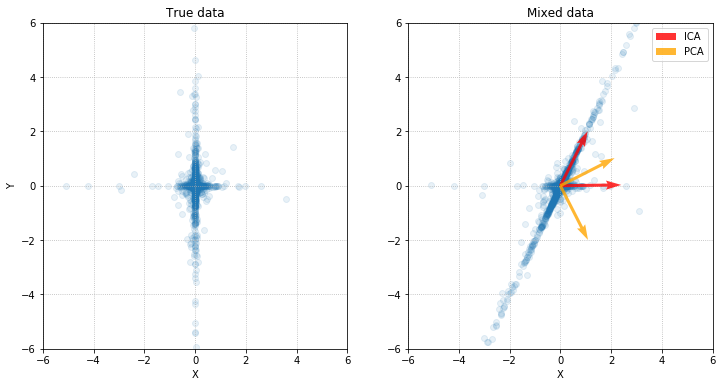

In [11]:
fig = plt.figure(figsize=(12,6))

plt.subplot(121)
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(linestyle="dotted")
plt.title("True data")
plt.scatter(S.T[:,0], S.T[:,1], alpha=0.1)

plt.subplot(122)
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.grid(linestyle="dotted")
plt.title("Mixed data")
plt.xlabel("X")
plt.scatter(X.T[:,0], X.T[:,1], alpha=0.1)

plt.quiver(0, 0, ica_mixing_0[0], ica_mixing_0[1], zorder=11, width=0.01, scale=5, color='r', alpha=0.8, label='ICA')
plt.quiver(0, 0, ica_mixing_1[0], ica_mixing_1[1], zorder=11, width=0.01, scale=5, color='r', alpha=0.8)

plt.quiver(0, 0, pca.components_[0,0], pca.components_[1,0], zorder=11, width=0.01, scale=5, color='orange', alpha=0.8, label='PCA')
plt.quiver(0, 0, pca.components_[0,1], pca.components_[1,1], zorder=11, width=0.01, scale=5, color='orange', alpha=0.8)

plt.legend()
plt.show()

## 2. Data whitening

Consider a generated dataset which is sampled from multivariate normal distribution with covariance matrix $C = \begin{pmatrix} 5 & 3 \\ 3 & 2 \end{pmatrix}$

In [8]:
# sample size
sample_size = 1000

# sample from multivariate Gaussian
mu = np.random.normal(0, 0.5, 2)
C = np.array([[5, 3], [3, 2]])
data = np.random.multivariate_normal(mu, C, size=sample_size)

In [9]:
idx = (data[:,0] > 3) & (data[:,1] > 3)

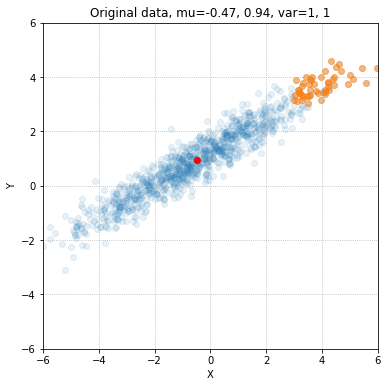

In [12]:
fig = plt.figure(figsize=(6,6))
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.grid(linestyle="dotted")

plt.title("Original data, mu={:.2f}, {:.2f}, var=1, 1".format(mu[0], mu[1]))
plt.xlabel("X")
plt.ylabel("Y")
plt.scatter(data[:,0], data[:,1], alpha=0.1)
plt.scatter(data[idx,0], data[idx,1], alpha=0.5)
plt.scatter(mu[0], mu[1], alpha=1, c='r')
plt.show()

Whitening has two simple steps:

1. Project the dataset onto the eigenvectors. This rotates the dataset so that there is no correlation between the components.

2. Normalize the the dataset to have a variance of 1 for all components. This is done by simply dividing each component by the square root of its eigenvalue.

Let $\mathbf{S} = \mathbf{V} \mathbf{\Lambda} \mathbf{V}^T$ is eigenvalue decomposition of sample covariance matrix $\mathbf{S} \triangleq \mathbf{X}^T\mathbf{X}$.

Then whitening matrix $\mathbf{W}$ is defined as:

$$\mathbf{W} = \mathbf{V} \mathbf{\Lambda}^{-1/2} \mathbf{V^T}$$

or alternatively (PCA variant): 

$$\mathbf{W} = \mathbf{V} \mathbf{\Lambda}^{-1/2}$$

Whitening transform is defined as:

$$\mathbf{X}' = \mathbf{W} \mathbf{X}$$

#### Exercise

Implement whitening matrix and whitening transform. Use either `scipy.linalg.fractional_matrix_power` or properties of diagonal matrix to raise it into power of $-1/2$.

In [12]:
# get sample mean
x_mean = 

# center data
data_centered = 

# compute covariance matrix
covariance = 
print("Covariance matrix:\n", covariance)

# obtain eigenvectors of covariance matrix
eigenvalues, eigenvectors = 
print("Eigenvalues:\n", eigenvalues)
print("Eigenvectors:\n", eigenvectors)

# compute whitening matrix
W_zca = 
print("ZCA Whitening matrix:\n", W_zca)

# compute PCA whitening matrix
W = 
print("PCA whitening matrix:\n", W)

# compute whitened data
data_scaled = StandardScaler().fit_transform(data) #np.dot(data_centered, W)
data_whitened = 
data_whitened_zca = 

SyntaxError: invalid syntax (<ipython-input-12-4fab95c60f8d>, line 2)

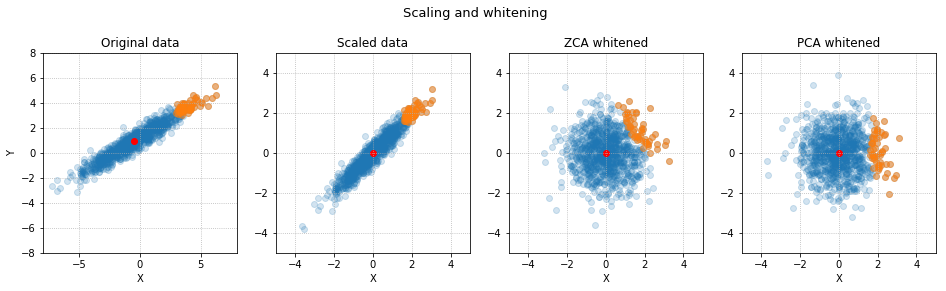

In [14]:
fig = plt.figure(figsize=(16,4))

plt.suptitle("Scaling and whitening", fontsize=13)

plt.subplot(141)
plt.xlim(-8, 8)
plt.ylim(-8, 8)
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(linestyle="dotted")
plt.title("Original data")
plt.scatter(data[:,0], data[:,1], alpha=0.2)
plt.scatter(data[idx,0], data[idx,1], alpha=0.5)
plt.scatter(mu[0], mu[1], alpha=1, c='r')

plt.subplot(142)
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.grid(linestyle="dotted")
plt.title("Scaled data")
plt.xlabel("X")
plt.scatter(data_scaled[:,0], data_scaled[:,1], alpha=0.2)
plt.scatter(data_scaled[idx,0], data_scaled[idx,1], alpha=0.5)
plt.scatter(np.mean(data_scaled, axis=0)[0], np.mean(data_scaled, axis=0)[1], alpha=1, c='r')

plt.subplot(144)
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.grid(linestyle="dotted")
plt.title("PCA whitened")
plt.xlabel("X")
plt.scatter(data_whitened[:,0], data_whitened[:,1], alpha=0.2)
plt.scatter(data_whitened[idx,0], data_whitened[idx,1], alpha=0.5)
plt.scatter(np.mean(data_whitened, axis=0)[0], np.mean(data_whitened, axis=0)[1], alpha=1, c='r')

plt.subplot(143)
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.grid(linestyle="dotted")
plt.title("ZCA whitened")
plt.xlabel("X")
plt.scatter(data_whitened_zca[:,0], data_whitened_zca[:,1], alpha=0.2)
plt.scatter(data_whitened_zca[idx,0], data_whitened_zca[idx,1], alpha=0.5)
plt.scatter(np.mean(data_whitened_zca, axis=0)[0], np.mean(data_whitened_zca, axis=0)[1], alpha=1, c='r')

plt.subplots_adjust(top = 0.82)

plt.show()

## 3. ICA solution

### Kurtosis approach - make the output signal components most non-Gaussian

ICA algorithm is conceptually relatively simple and works as follows:

1. remove the mean and whiten the data
2. rotate the data such that output signal components are most non-Gaussian.

Consider a linear mixture of two sources: $X_1 \sim Laplace(0,1)$ and $X_2 \sim U(0,1)$:

In [18]:
# sample size and dimensionality
n, d = 5000, 2

X_1 = np.random.uniform(-np.sqrt(3),np.sqrt(3), (n))
X_2 = np.random.laplace(0, 1, (n))
X = np.vstack([X_1, X_2])
X.shape

(2, 5000)

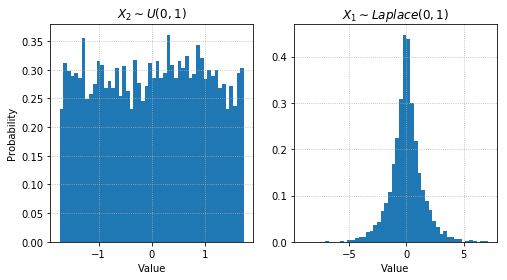

In [19]:
fig = plt.figure(figsize=(8,4))

plt.subplot(121)
#plt.xlim(-5, 5)
#plt.ylim(-5, 5)
plt.xlabel("Value")
plt.ylabel("Probability")
plt.grid(linestyle="dotted")
plt.title("$X_2 \sim U(0,1)$")
plt.hist(X_1, bins=50, density=True)

plt.subplot(122)
#plt.xlim(-5, 5)
#plt.ylim(-5, 5)
plt.grid(linestyle="dotted")
plt.title("$X_1 \sim Laplace(0,1)$")
plt.xlabel("Value")
plt.hist(X_2, bins=50, density=True)

plt.show()

By defining random mean and random mixing matrix $M$  obtain mixed data:

In [20]:
# set random mean
mean = np.random.normal(0, 0.5, d)

# create random mixing matrix
M = np.random.normal(0, 1, (d, d))

# mix initial sources and add mean.
Y = np.dot(M, X) + mean.reshape((2, 1))

print("\nInitial sources:\n", X)
print("\nInitial mean:\n", mean)
print("\nMixing matrix:\n", M)
print("\nMixed data:\n", Y)


Initial sources:
 [[-0.34031393 -0.668155   -0.70088669 ... -0.60778975 -1.66361933
  -0.0451357 ]
 [-0.64995962  0.13833922 -0.80341007 ... -0.62599539 -0.52842076
   0.19031963]]

Initial mean:
 [-0.83464852 -0.28925845]

Mixing matrix:
 [[-1.36715723 -0.52259537]
 [ 0.62925729 -0.80601217]]

Mixed data:
 [[-0.02971998  0.00652898  0.54343216 ...  0.32343792  1.71593092
  -0.87240108]
 [ 0.02047189 -0.82120295 -0.08273822 ... -0.16715468 -0.91018948
  -0.47106035]]


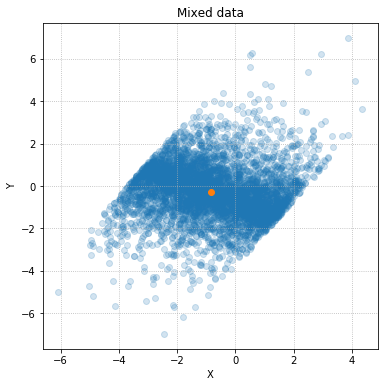

In [21]:
fig = plt.figure(figsize=(6,6))

plt.xlabel("X")
plt.ylabel("Y")
plt.grid(linestyle="dotted")
plt.title("Mixed data")
plt.scatter(Y[0], Y[1], alpha=0.2)
plt.scatter(np.mean(Y.T, axis=0)[0], np.mean(Y.T, axis=0)[1], alpha=1)

plt.show()

In [22]:
def white(data):
    x_mean = np.mean(data, axis=1)
    data_centered = data - x_mean.reshape((2, 1))
    covariance = data_centered.dot(data_centered.T) / n
    eigenvalues, eigenvectors = np.linalg.eig(covariance)
    W = eigenvectors.dot(matrix_power(np.diag(eigenvalues), -0.5)).dot(eigenvectors.T)
    return np.dot(W, data_centered), data_centered, W

**Step 1:** whiten the data

In [23]:
Y_white, Y_centered, W = white(Y)
Y_white.shape, Y_centered.shape

((2, 5000), (2, 5000))

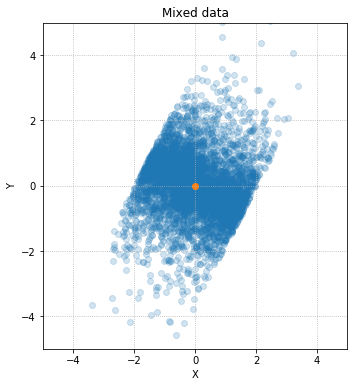

In [24]:
fig = plt.figure(figsize=(12,6))

plt.subplot(121)
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(linestyle="dotted")
plt.title("Whiten data")
plt.scatter(Y_white[0], Y_white[1], alpha=0.2)
plt.scatter(np.mean(Y_white, axis=1)[0], np.mean(Y_white, axis=1)[1], alpha=1)

plt.show()

#### Exercise

Define function for calculating fourth order autocumulants for zero mean data.

The loss (contrast) function is based on fourth order auto cumulants, which are calculated with the following function.

Four-order cumulant (corrected moment) is defined:

$$C_{iiii} = M_{iiii} - 3 \cdot M_{ii}^2$$

In [25]:
def fourthOrderAutoCumulants(data_centered):
    
    moment2ndOrder = np.average(data_centered ** 2, axis=1)
    moment4thOrder = np.average(data_centered ** 4, axis=1)
    cumulants4thOrder = 
    
    return cumulants4thOrder

In [26]:
print(fourthOrderAutoCumulants(Y_white))

[-0.63781377  1.80019998]


Define contrast function for whitened data.

The contrast function is a scalar function that quantifies on the basis of fourth order cumulants how non-Gaussian the components of a signal are:

$$\Psi := \sum_i C_{iiii}^2$$

In [27]:
def contrastFunction(whitenedData):
    cumulants = fourthOrderAutoCumulants(whitenedData)
    contrast = 
    
    return contrast

In [28]:
print(contrastFunction(Y_white))

3.6475263766282255


#### Exercise

**Step 2:** Find optimal rotation angle with random Givens rotations.

In higher dimensions a rotation matrix can be quite complex. To keep things simple, we use Givens rotations, which are defined as a rotation within the 2D subspace spanned by two axes n and m. For instance a  rotation matrix in 2D is given by:

$$\mathbf{R} = \begin{pmatrix} cos \phi & sin \phi \\ -sin \phi & cos \phi \end{pmatrix}$$

A rotation within the plane spanned by the second and the fourth axis ($n$ = 2, $m$ = 4) of a four-dimensional space is given by

$$\mathbf{R} = \begin{pmatrix} 1 & 0 & 0 & 0 \\ 0  & cos \phi & 0 & sin \phi \\ 0 & 0 & 1 & 0 \\ 0 & -sin \phi & 0 & cos \phi \end{pmatrix}$$

It can be shown that any general rotation, i.e. any orthogonal matrix with positive determinant, can be written as a product of Givens-rotations. Thus, we can find the general rotation matrix of the ICA problem by applying a series of Givens rotations and each time improve the objective function. By applying enough of such Givens-rotations, the algorithm should eventually converge to the globally optimal solution.

This is a simple procedure to rotate the data such that the contrast function is maximized, i.e. such that the components are maximally non-Gaussian, which implies that the components are minimally statistically independent (as far as fourth order is concerned).

In [29]:
# Start with rotation angle 0, i.e. with rotation matrix [[1,0],[0,1]] and contrast of the whitened data.

bestAngle = 0
bestRotationMatrix = np.array([[1,0],[0,1]])
bestRotatedContrast = contrastFunction(Y_white)

angle = 0
for iteration in np.arange(0, 30, 0.01):

    # Try a new rotation angle near the old one.
    angle = angle + np.random.normal(0,m.exp(-iteration))    # Vary the angle a bit, where 'a bit' gets exponentially smaller.
    rotationMatrix = np.array([[m.cos(angle),-m.sin(angle)],[m.sin(angle),m.cos(angle)]]) # Calculate new rotation matrix.
    rotatedData = np.dot(rotationMatrix, Y_white)        # Calculate rotated whitened data.
    rotatedContrast = contrastFunction(rotatedData)          # Calculate contrast ov newly rotated whitened data.
    
    # If contrast has improved, keep the new rotation angle, matrix, and contrast, otherwise continue with the old ones.
    if rotatedContrast > bestRotatedContrast:
        bestAngle = angle
        print(m.cos(angle), m.sin(angle))                     # Print the cos and sin of the improved angle to demonstrate progress (the angle is not so useful, since it has a 2pi periodicity, and the problem has a 90° symmetry)
        bestRotationMatrix = rotationMatrix
        bestRotatedContrast = rotatedContrast
        
# Display final result.
print("Best angle: ", bestAngle)
print("Best rotation matrix:\n", bestRotationMatrix)
print("Best rotated contrast: ", bestRotatedContrast)

0.990823889203 0.135159241581
0.622724019752 -0.782441560261
-0.245530594027 0.969388842208
-0.587069986822 0.809536182374
0.891102086932 0.453802898477
0.444245193995 -0.895905244773
0.897081227506 0.441865671054
0.898204569636 0.4395776963
Best angle:  -5.82805685218
Best rotation matrix:
 [[ 0.89820457 -0.4395777 ]
 [ 0.4395777   0.89820457]]
Best rotated contrast:  9.51464124645214


#### Exercise

Find unmixing matrix $\mathbf{U} = \mathbf{R} \mathbf{W}$ and separated sources $\mathbf{S} = \mathbf{U} \mathbf{\bar{Y}}$, where $\mathbf{\bar{Y}}$ is centered data.

In [30]:
# find unmixing matrix U
U = 

# find separated sources S
S = 

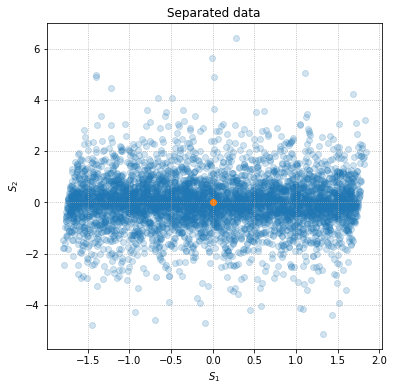

In [31]:
fig = plt.figure(figsize=(6,6))

plt.xlabel("$S_1$")
plt.ylabel("$S_2$")
plt.grid(linestyle="dotted")
plt.title("Separated data")
plt.scatter(S[0], S[1], alpha=0.2)
plt.scatter(np.mean(S, axis=1)[0], np.mean(S, axis=1)[1], alpha=1)

plt.show()

#### Exercise

Plot the distribution of separated sources

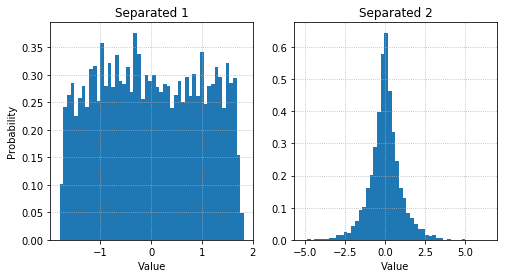

In [32]:
fig = plt.figure(figsize=(8,4))

plt.subplot(121)
#plt.xlim(-5, 5)
#plt.ylim(-5, 5)
plt.xlabel("Value")
plt.ylabel("Probability")
plt.grid(linestyle="dotted")
plt.title("Separated 1")
plt.hist(S[0], bins=50, density=True)

plt.subplot(122)
#plt.xlim(-5, 5)
#plt.ylim(-5, 5)
plt.grid(linestyle="dotted")
plt.title("Separated 2")
plt.xlabel("Value")
plt.hist(S[1], bins=50, density=True)

plt.show()

Ideally the unmixing matrix $\textbf{U}$ is the inverse of the mixing matrix $\textbf{M}$, and thus $\textbf{U}\textbf{M}=\textbf{1}$.  However ICA can only be expected to work up to a permutation and different scaling of the sources, thus $\textbf{U}\textbf{M}$ should look like a permutation matrix with arbitrary (but significantly different from zero) numbers instead of the ones, i.e. each row and each column should contain exactly one entry significantly different from 0.  However, since in our case the true sources as well as the estimated sources are normalized to variance one, the non-zero elements should be close to $\pm1$.

#### Exercise

Formally check whether your unmixing matrix is correct. Show they are true up to permutation and scaling.

In [33]:
# your code here


array([[-1.00769637, -0.03108764],
       [ 0.04591477, -0.7105342 ]])

## 4. Real data

### 4.1. Blind source separation

In [34]:
# set image size
shape = (512, 512)
rows, cols = shape

# load images
img1 = np.load('./data/camera.npy').flatten()
img2 = np.load('./data/astronaut.npy').flatten()
img3 = np.load('./data/moon.npy').flatten()
img4 = np.load('./data/noise.npy').flatten()

# combine images
S = np.c_[img1, img2, img3, img4].T

In [35]:
# set random mixing matrix A
A = np.random.uniform(0.2, 0.8, (4, 4))

# mix data
X = np.dot(A, S)

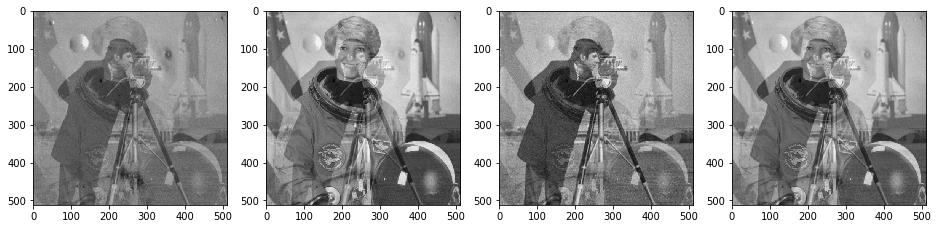

In [36]:
# show images
f, ax = plt.subplots(1, X.shape[0])
f.set_size_inches((16,4))

for i in range(X.shape[0]):
    ax[i].imshow(X[i,:].reshape(rows, cols), cmap=plt.gray())

#### Exercise

Run ICA with different number of `n_components`. Compare results, conclude.

In [37]:
# run ICA
ica = FastICA(n_components=2)
img_ica = ica.fit_transform(X.T)

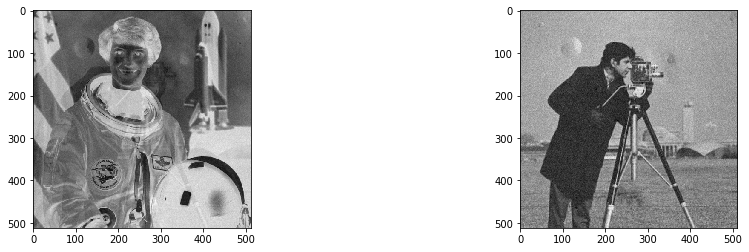

In [38]:
# show images
f, ax = plt.subplots(1, img_ica.shape[1])
f.set_size_inches((16,4))

for i in range(img_ica.shape[1]):
    ax[i].imshow(img_ica[:,i].reshape(shape), cmap=plt.gray())

### 4.2. Time series

In [39]:
np.random.seed(42)
n_samples = 2000
time = np.linspace(0, 8, n_samples)

s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal
s2 = np.sign(np.sin(3.5 * time))  # Signal 2 : square signal
s3 = signal.sawtooth(1.5 * np.pi * time) # sawtooteh

S = np.c_[s1, s2, s3]
#S += np.array([0, 0, np.random.normal()])  # Add noise

S /= S.std(axis=0)  # Standardize data

# Mix data
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])  # Mixing matrix
#A = np.random.normal(0, 1, (3, 3))
X = np.dot(S, A.T)  # Generate observations

# Compute ICA
ica = FastICA(n_components=3)
S_ = ica.fit_transform(X)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix

# We can `prove` that the ICA model applies by reverting the unmixing.
#assert np.allclose(X, np.dot(S_, A_.T) + ica.mean_)

# For comparison, compute PCA
pca = PCA(n_components=3)
H = pca.fit_transform(X)  # Reconstruct signals based on orthogonal components

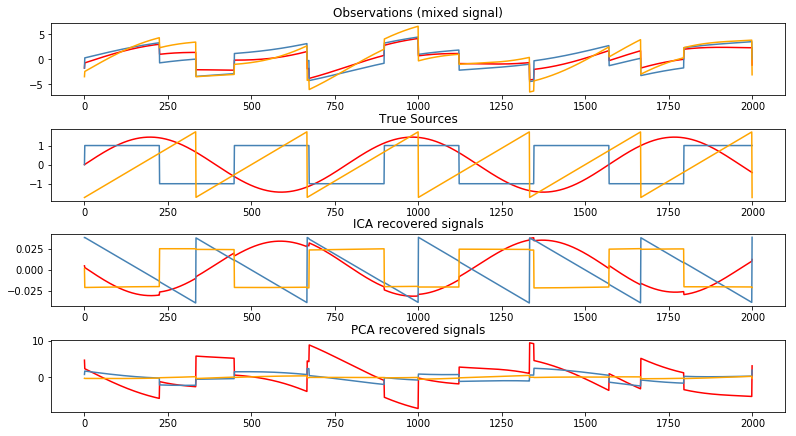

In [40]:
fig = plt.figure(figsize=(12,6))

models = [X, S, S_, H]
names = ['Observations (mixed signal)',
         'True Sources',
         'ICA recovered signals',
         'PCA recovered signals']
colors = ['red', 'steelblue', 'orange']

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(4, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

plt.subplots_adjust(0.09, 0.04, 0.94, 0.94, 0.26, 0.46)
plt.show()